In [9]:
%matplotlib inline
from desc.equilibrium import EquilibriaFamily
from desc.plotting import plot_surfaces
from desc.objectives import MagneticWell
from desc.grid import LinearGrid
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# comment these two lines if not using a dark theme
from jupyterthemes import jtplot
jtplot.style()

In [2]:
class MagneticWellVisualizer:

    x = 0
    y = 1

    def __init__(
        self,
        name,
        has_stellopt_data=False,
        use_stellopt_rho=False,
        rho=np.linspace(1 / 30, 1, 30),
    ):
        self.name = name
        # collect final equilibrium
        self.eq = EquilibriaFamily.load(
            load_from="examples/DESC/" + name + "_output.h5"
        )[-1]
        self.st = dict()  # values are tuples of (x[i], y[i]) arrays of plotable data

        if has_stellopt_data:
            # pull stellopt data from matlab .mat file
            mat = sio.loadmat("magwell-data/" + name + "_magwell.mat")
            self.st["STELLOPT Magnetic Well"] = mat["rho"], mat["magwell"]
            if use_stellopt_rho:
                rho = self.st["STELLOPT Magnetic Well"][MagneticWellVisualizer.x]

        # cached when compute_magwell() is called
        self.rho = rho
        self.st["DESC Magnetic Well"] = rho, np.empty(len(rho))
        self.st["V surface integral"] = rho, np.empty(len(rho))
        self.st["V"] = rho, np.empty(len(rho))
        self.st["dv_drho"] = rho, np.empty(len(rho))
        self.st["pressure_average"] = rho, np.empty(len(rho))
        self.st["Bsquare_average"] = rho, np.empty(len(rho))
        self.st["p_r"] = rho, np.empty(len(rho))

    def print_values(self, grid=None):
        # print the results of compute_magwell() for the rho=1 surface if no grid given
        # the volume enclosed by the rho=1 surface should match data["V"],
        # the entire volume, but it doesn't

        m = MagneticWell(eq=self.eq, grid=grid).compute(
            # uses the default grid where rho = 1 if grid is none
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.p_l,
            self.eq.i_l,
            self.eq.Psi,
        )
        print(self.name)
        print(self.eq)
        print("volume enclosed by the rho=1 surface: " + str(m["V surface integral"]))
        print("dv/drho: " + str(m["dv_drho"]))
        print('total volume (data["V"]): ' + str(m["data"]["V"]))
        print("pressure_average: " + str(m["pressure_average"]))
        print("Bsquare_average: " + str(m["Bsquare_average"]))
        # p_r[0] is p_r[i] for all i. is that a problem?
        print("dpressure/drho: " + str(m["data"]["p_r"]))
        print("DESC Magnetic Well: " + str(m["DESC Magnetic Well"]))
        print()

    def compute_magwell(self):
        # compute and cache MagneticWell.compute() values
        # for the given array of rho=constant surfaces

        for i in range(len(self.rho)):
            grid = LinearGrid(
                L=1,
                M=2 * self.eq.M_grid + 10,
                N=2 * self.eq.N_grid + 10,
                NFP=self.eq.NFP,
                sym=self.eq.sym,
                rho=self.rho[i],
            )
            m = MagneticWell(eq=self.eq, grid=grid).compute(
                self.eq.R_lmn,
                self.eq.Z_lmn,
                self.eq.L_lmn,
                self.eq.p_l,
                self.eq.i_l,
                self.eq.Psi,
            )
            assert (
                m["check_derivs_B_r"] and m["check_derivs_p_r"]
            ), "derivatives not computed"

            # cache computed quantity in the y coordinate array of the proper key
            for key, val in m.items():
                if key == "data":
                    # V(rho[i]) = data["V"]
                    self.st["V"][MagneticWellVisualizer.y][i] = val["V"]
                    self.st["p_r"][MagneticWellVisualizer.y][i] = val["p_r"][0]
                else:
                    # don't want to plot check_derivs keys used in assertions
                    if key in self.st:
                        self.st[key][MagneticWellVisualizer.y][i] = val

    def plot(self, width=5, height=5):
        # plot all quantities cached from compute_magwell()
        # and STELLOPT data if it exists

        fig, ax = plt.subplots(ncols=len(self.st))
        fig.set_size_inches(len(self.st) * width, height)

        i = 0
        for key, val in self.st.items():
            x = val[MagneticWellVisualizer.x]
            y = val[MagneticWellVisualizer.y]
            ax[i].scatter(x, y)
            ax[i].plot(x, y)
            ax[i].set_title(self.name + ": " + key)
            i += 1

In [3]:
dshape = MagneticWellVisualizer(
    "DSHAPE", has_stellopt_data=True, use_stellopt_rho=False
)
heliotron = MagneticWellVisualizer(
    "HELIOTRON", has_stellopt_data=True, use_stellopt_rho=False
)
axisym = MagneticWellVisualizer("AXISYM", has_stellopt_data=False)

(<Figure size 288x360 with 1 Axes>,
 array([<AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

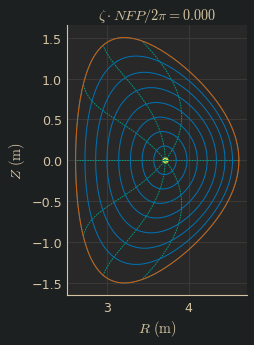

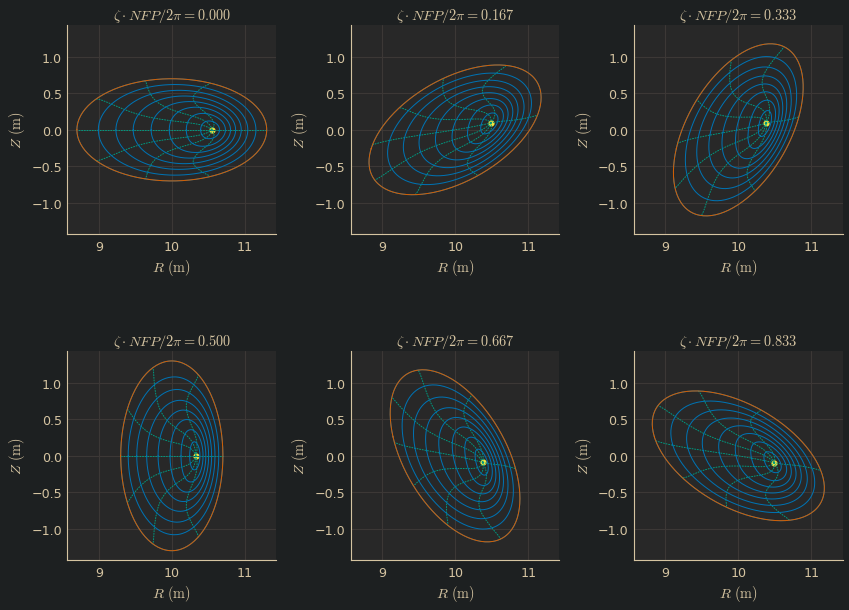

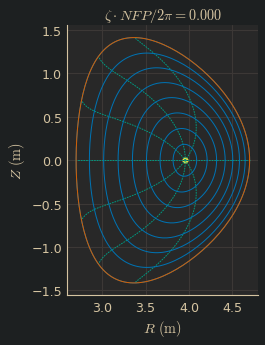

In [10]:
# just to make sure equilibrium were solved correctly on my computer
plot_surfaces(dshape.eq)
plot_surfaces(heliotron.eq)
plot_surfaces(axisym.eq)

In [5]:
dshape.print_values()
heliotron.print_values()
axisym.print_values()

DSHAPE
Equilibrium at 0x7f599c10a8b0 (L=26, M=13, N=0, NFP=1.0, sym=1, spectral_indexing=fringe)
volume enclosed by the rho=1 surface: 77.2858274674659
dv/drho: 135.23615209008204
total volume (data["V"]): 168.593195468514
pressure_average: 7.719369910847546e-05
Bsquare_average: 0.05766179166752265
dpressure/drho: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [6]:
# generate data for plots
dshape.compute_magwell()
heliotron.compute_magwell()

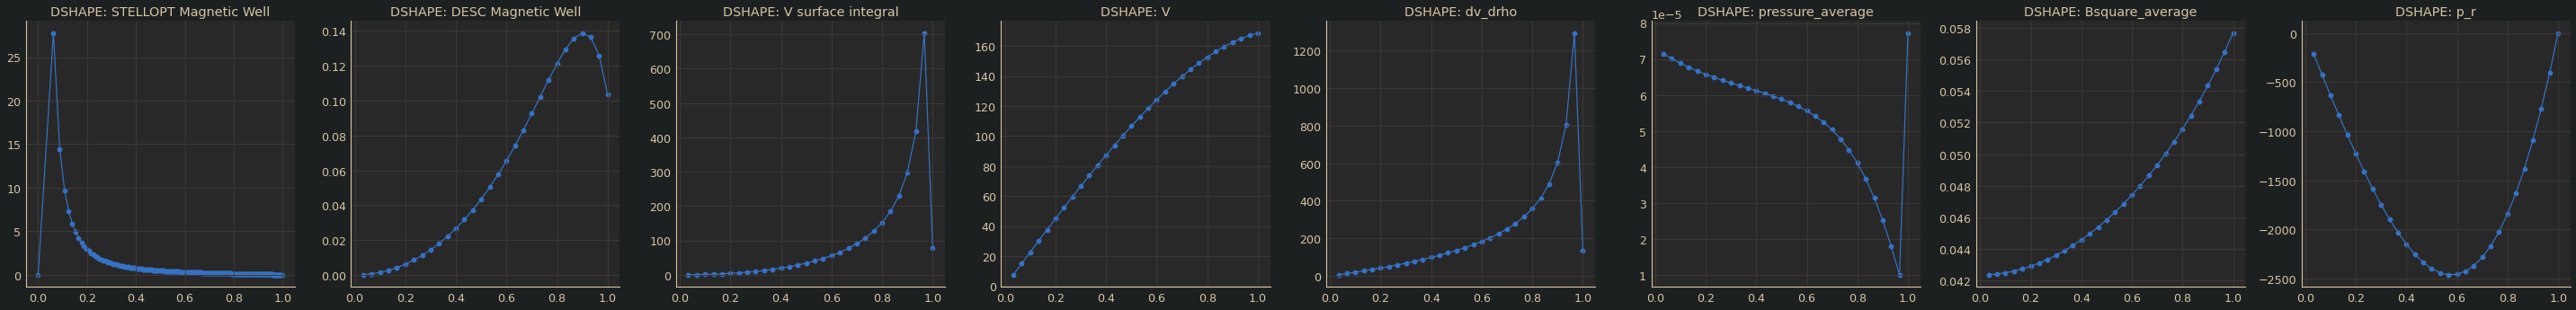

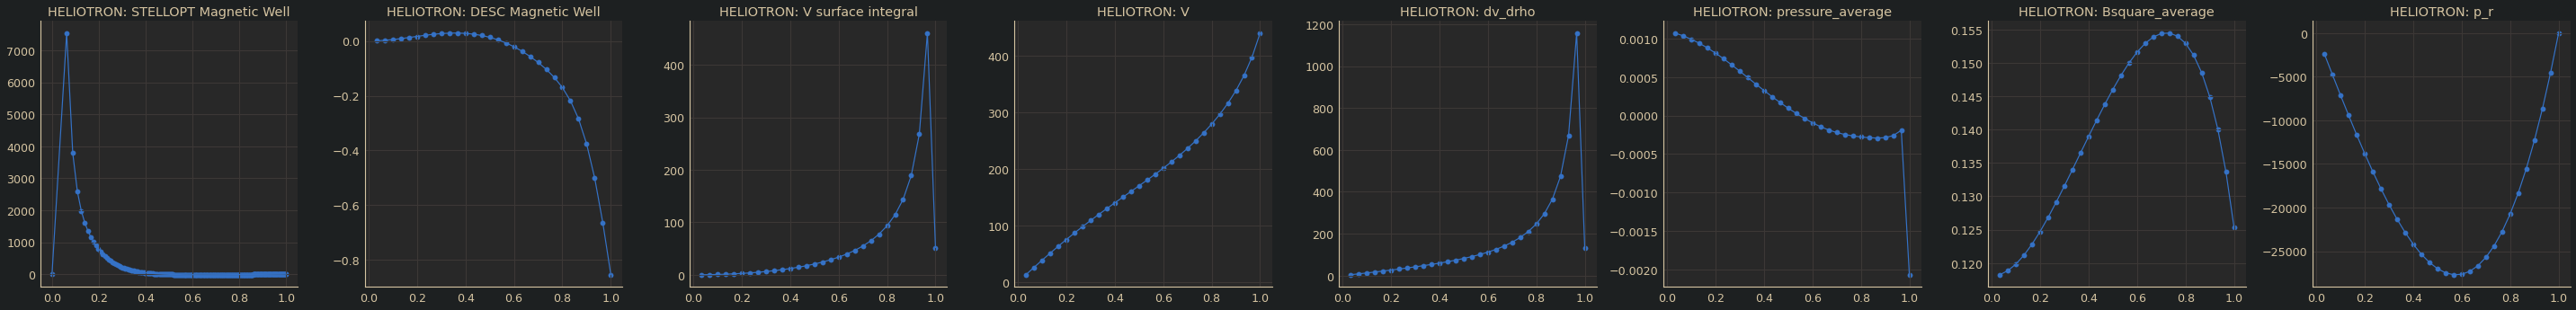

In [11]:
dshape.plot()
heliotron.plot()

![DSHAPE_magwell.png](magwell-data/DSHAPE_magwell.png)

![HELIOTRON_magwell.png](magwell-data/HELIOTRON_magwell.png)

In [8]:
# also what rho=constant surface does MagneticWell return a result for when the rho input for grid is an array?
grid = LinearGrid(
    M=2 * dshape.eq.M_grid + 10,
    N=2 * dshape.eq.N_grid + 10,
    NFP=dshape.eq.NFP,
    sym=dshape.eq.sym,
    rho=np.linspace(1 / 10, 1, 10),
)
dshape.print_values(grid)

DSHAPE
Equilibrium at 0x7f599c10a8b0 (L=26, M=13, N=0, NFP=1.0, sym=1, spectral_indexing=fringe)
volume enclosed by the rho=1 surface: 334.7779949430351
dv/drho: 925.2510529718564
total volume (data["V"]): 107.52311344942777
pressure_average: 1.1379612132481184e-05
Bsquare_average: 0.049994412811442054
dpressure/drho: [-633.6 -633.6 -633.6 ...    0.     0.     0. ]
DESC Magnetic Well: [0.07620139]

